# Refactor bus corridors

In [1]:
import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

from siuba import *

import utilities
import A1_rail_ferry_brt as rail_ferry_brt
import B1_bus_corridors as bus_corridors

from shared_utils import rt_utils

GCS_FILE_PATH = utilities.GCS_FILE_PATH

analysis_date = rail_ferry_brt.analysis_date

import dask.dataframe as dd
import dask_geopandas


itp_id = 182
date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
'''
FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"
        
routelines = dask_geopandas.read_parquet(f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
trips = dd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
stop_times = dd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
stops = dask_geopandas.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")

gdf = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)
gdf.to_parquet("./data/182_bus2.parquet")
'''

'\nFILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"\n        \nroutelines = gpd.read_parquet(f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")\ntrips = dd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")\nstop_times = dd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")\nstops = dask_geopandas.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")\n\ngdf = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)\ngdf.to_parquet("./data/182_bus2.parquet")\n'

In [6]:
# calitp-analytics-data/data-analyses/high_quality_transit_areas/bus_corridors/182_bus.parquet
eric = gpd.read_parquet(f"{GCS_FILE_PATH}bus_corridors/182_bus.parquet")

In [7]:
tiff = gpd.read_parquet(f"./data/182_bus2.parquet")

In [8]:
def stats(df):
    print(df.columns)
    print(df.dtypes)
    print(f"# obs: {len(df)}")
    print(f"# unique stops: {df.stop_id.nunique()}")
    print(f"sum am_max stops: {df.am_max_trips.sum()}")
    print(f"sum pm_max stops: {df.am_max_trips.sum()}")
    print(f"# unique hqta_segment_id: {df.hqta_segment_id.nunique()}")

    
def compare(eric, tiff):
    print("***********Eric************")
    stats(eric)
    print("***********Tiff************")
    stats(tiff)

In [9]:
compare(eric, tiff)

***********Eric************
Index(['calitp_itp_id', 'calitp_url_number', 'shape_id', 'geometry',
       'segment_sequence', 'hqta_segment_id', 'stop_id', 'am_max_trips',
       'pm_max_trips', 'hq_transit_corr', 'departure_hour', 'n'],
      dtype='object')
calitp_itp_id           int64
calitp_url_number       int64
shape_id               object
geometry             geometry
segment_sequence       object
hqta_segment_id         int64
stop_id                object
am_max_trips          float64
pm_max_trips          float64
hq_transit_corr          bool
departure_hour        float64
n                     float64
dtype: object
# obs: 2503
# unique stops: 2233
sum am_max stops: 15682.0
sum pm_max stops: 15682.0
# unique hqta_segment_id: 2503
***********Tiff************
Index(['calitp_itp_id', 'calitp_url_number', 'stop_id', 'hqta_segment_id',
       'segment_sequence', 'shape_id', 'geometry', 'am_max_trips',
       'pm_max_trips', 'hq_transit_corr'],
      dtype='object')
calitp_itp_id    

In [ ]:
explore_shapes = [
    "700292_FEB22",
    #"400916_FEB22",
]

explore_stops = [
    "6535",
    "5383"
]

In [14]:
explore_stops = tiff[tiff.shape_id.str.startswith("720")].stop_id.unique().tolist()

<AxesSubplot:>

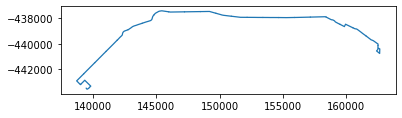

In [23]:
tiff[tiff.shape_id.str.startswith("720")].plot()

<AxesSubplot:>

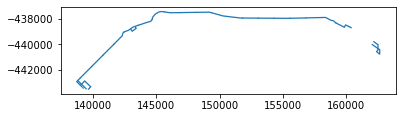

In [22]:
eric[eric.shape_id.str.startswith("720")].plot()

<AxesSubplot:>

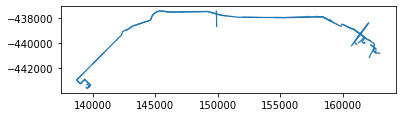

In [18]:
tiff[tiff.stop_id.isin(explore_stops)].plot()

<AxesSubplot:>

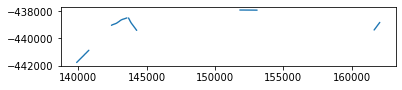

In [19]:
eric[eric.stop_id.isin(explore_stops)].plot()

In [ ]:
eric[eric.stop_id.isin(explore_stops)].plot(column="segment_sequence")

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)]

In [ ]:
tiff[tiff.stop_id=="6535"]

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)].plot(column="segment_sequence")

In [ ]:
m1 = pd.merge(
    eric,
    tiff,
    on = ["calitp_itp_id", "calitp_url_number", "shape_id", 
          "hqta_segment_id", "segment_sequence", "stop_id"],
    how = "outer",
    #validate="m:m",
    indicator=True
)

### Find trips that are just AM / PM peak

In [ ]:
import dask_utils

FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"

trips = dd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
stop_times = dd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")

In [ ]:
stop_times2 = dask_utils.fix_departure_time(stop_times)

In [ ]:
stop_cols = ["calitp_itp_id", "stop_id"]

trip_stops_by_hour = (stop_times2.groupby(["trip_id"] + stop_cols + ["departure_hour"])
    .agg({"trip_key": "count"})
 .reset_index()
 .rename(columns = {"trip_key": "n_trips"})
)

In [ ]:
trip_stops_by_hour["time_of_day"] = trip_stops_by_hour.apply(lambda x:
        rt_utils.categorize_time_of_day(x.departure_hour), axis=1, 
                                           meta = ("time_of_day", "str")
                                          )

In [ ]:
trip_stops_by_hour.time_of_day.compute().value_counts()

In [ ]:
# Remove trips that only run during AM/PM peak, because those don't qualify as HQTA
def invalid_trips_only_peak_hours(df):
    trip_cols = ["calitp_itp_id", "trip_id"]
    
    df = df.assign(
        is_am_peak = df.time_of_day.map(lambda x: 1 if x=="AM Peak" 
                                          else 0),
        is_pm_peak = df.time_of_day.map(lambda x: 1 if x=="PM Peak"
                                          else 0),
        is_other = df.time_of_day.map(lambda x: 1 if ((x != "AM Peak") and 
                                                        (x != "PM Peak"))
                                        else 0),
    )
    
    df2 = (df.groupby(trip_cols)
           .agg({"is_am_peak": np.max, 
                 "is_pm_peak": np.max,
                 "is_other": np.max,})
           .reset_index()
          )
    
    # Drop trips that only run AM/PM
    only_peak = df2[(df2.is_am_peak==1) & 
              (df2.is_pm_peak==1) & 
              (df2.is_other==0)].trip_id.compute()
        
    # Return list of trip_ids that are invalid
    return list(only_peak.unique())

In [ ]:
invalid_trips = invalid_trips_only_peak_hours(trip_stops_by_hour)

In [ ]:
# Aggregate how many trips are made at that stop by departure hour
trips_per_hour = (stop_times2.groupby(stop_cols + ["departure_hour"])
                  .agg({'trip_id': 'count'})
                  .reset_index()
                  .rename(columns = {"trip_id": "n_trips"})
                 )        

In [ ]:
trips_per_hour.compute()